# Compressing Color Spaces Using k-Means

One exciting application of $k$-means is the compression of image color spaces. For example,
a typical **true-color image** comes with a 24-bit color depth, allowing for a total of 16,777,216
color variations. However, in most images, a large number of the colors will be unused, and
many of the pixels in the image will have similar or identical colors.

Alternatively, we can use k-means to reduce the color palette to, for example, 16 color
variations. The trick here is to think of the cluster centers as the reduced color palette. Then
$k$-means will automatically organize the millions of colors in the original image into the
appropriate number of colors!

## Visualizing the true-color palette

Let's have a look at a particular image:

In [1]:
import cv2
import numpy as np
lena = cv2.imread('data/lena.jpg', cv2.IMREAD_COLOR)

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [3]:
plt.rc('axes', **{'grid': False})

Then we can visualize Lena with the following command (don't forget to switch the BGR
ordering of the color channels to RGB):

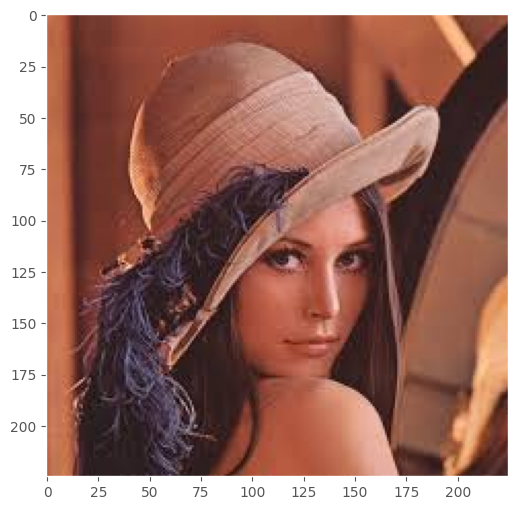

In [4]:
plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(lena, cv2.COLOR_BGR2RGB))

The image itself is stored in a 3D array of size (height, width, depth) containing
blue/green/red contributions as integers from 0 to 255:

In [5]:
lena.shape

(225, 225, 3)

Because every color channel has 256 possible values, the number of possible colors is 256 x
256 x 256, or 16,777,216, as mentioned prior to this. One way to visualize the sheer amount
of different colors in the image is to reshape the data to a cloud of points in a 3D color
space. We also scale the colors to lie between 0 and 1:

In [6]:
img_data = lena / 255.0 # use 0...1 scale
img_data = img_data.reshape((-1, 3))
img_data.shape

(50625, 3)

In this 3D color space, every row of `data` is a data point. In order to visualize this data, we
will write a function called `plot_pixels`, which takes as input the data matrix and a figure
title. Optionally, we also let the user specify the colors to use. For the sake of efficiency, we
can also limit the analysis to a subset of `N` pixels:

In [7]:
def plot_pixels(data, title, colors=None, N=10000):
    if colors is None:
        colors = data
    
    # choose a random subset
    rng = np.random.RandomState(0)
    i = rng.permutation(data.shape[0])[:N]
    colors = colors[i]
    pixel = data[i].T
    R, G, B = pixel[0], pixel[1], pixel[2]
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    ax[0].scatter(R, G, color=colors, marker='.')
    ax[0].set(xlabel='Red', ylabel='Green', xlim=(0, 1), ylim=(0, 1))

    ax[1].scatter(R, B, color=colors, marker='.')
    ax[1].set(xlabel='Red', ylabel='Blue', xlim=(0, 1), ylim=(0, 1))

    fig.suptitle(title, size=20);

We can then call the function with our data matrix (data) and an appropriate title:

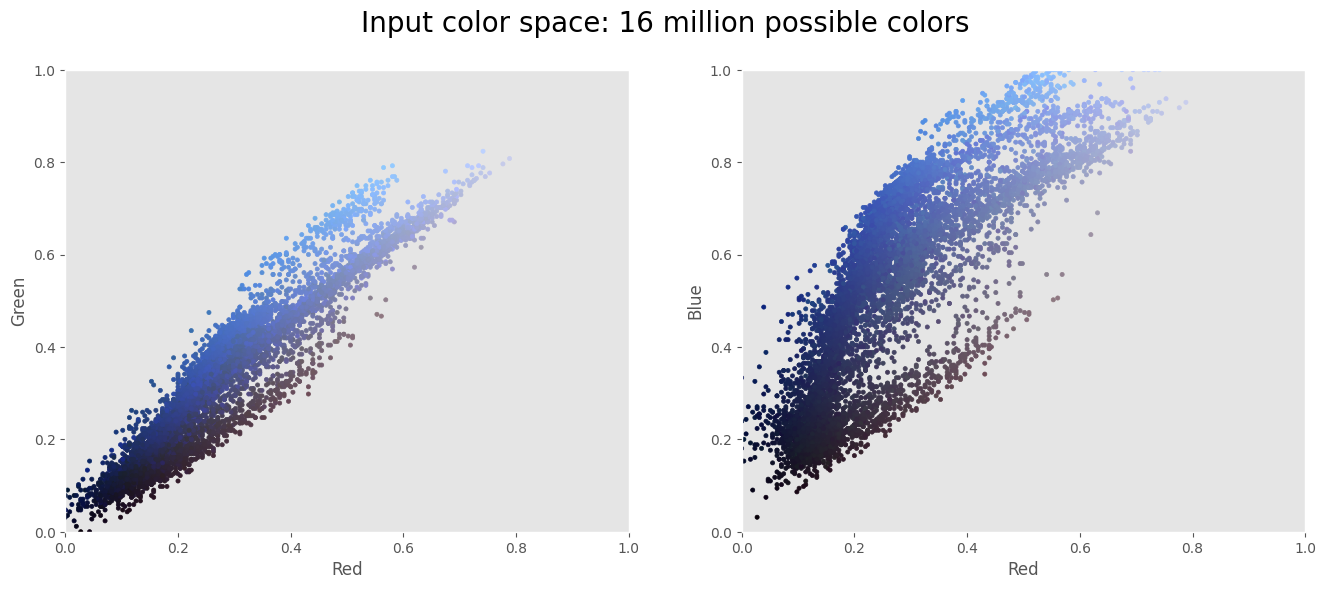

In [8]:
plot_pixels(img_data, title='Input color space: 16 million possible colors')

## Reducing the color palette using k-means

Now let's reduce these 16 million colors to just 16 colors by telling $k$-means to cluster all
color variations into 16 distinct clusters. We use the before mentioned procedure, but now
specify 16 as the number of clusters:

In [9]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
flags = cv2.KMEANS_RANDOM_CENTERS
compactness, labels, centers = cv2.kmeans(img_data.astype(np.float32),
                                          16, None, criteria, 10, flags)

The resulting cluster corresponds to the 16 colors of our reduced color palette. Visual
inspection of the centers array reveals that all colors have three entries—B, G, and R—with
values between 0 and 1:

In [10]:
centers

array([[0.04678524, 0.02799818, 0.10396719],
       [0.19499989, 0.17284413, 0.26607278],
       [0.49899313, 0.61490333, 0.8668845 ],
       [0.29749316, 0.38353726, 0.6651306 ],
       [0.13770083, 0.21434881, 0.48593327],
       [0.19184522, 0.21516825, 0.40984827],
       [0.5726756 , 0.5362428 , 0.6036686 ],
       [0.11796228, 0.11718145, 0.20391545],
       [0.16154447, 0.22726887, 0.4820188 ],
       [0.6382372 , 0.690645  , 0.8777667 ],
       [0.0622549 , 0.1495098 , 0.49803922],
       [0.5196079 , 0.5656863 , 0.6892157 ],
       [0.22313748, 0.2766734 , 0.5156415 ],
       [0.5164517 , 0.57026243, 0.7615211 ],
       [0.20291933, 0.2772012 , 0.5793109 ],
       [0.46116364, 0.5082268 , 0.70720565]], dtype=float32)

These 16 colors correspond to the 16 cluster labels contained in the labels vector. So we
want all data points with label 0 to be colored according to row 0 in the `centers` array; all
data points with label 1 to be colored according to row 1 in the `centers` array; and so on. In
other words, we want to use labels as an index into the `centers` array—these are our
new colors:

In [11]:
new_colors = centers[labels].reshape((-1, 3))

We can plot the data again, but this time, we will use `new_colors` to color the data points
accordingly:

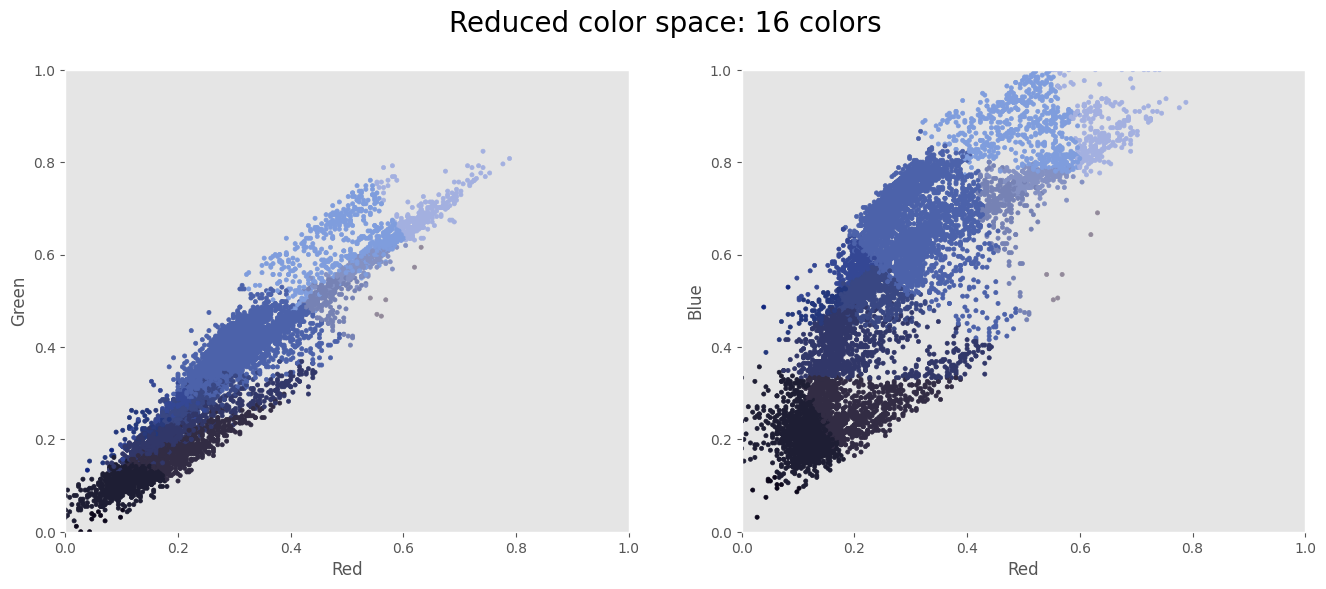

In [12]:
plot_pixels(img_data, colors=new_colors, title="Reduced color space: 16 colors")

In order to see the effect of this recoloring, we have to plot `new_colors` as an image. In
order to get from the image to the data matrix, we flattened the earlier image. Now we need
to do the inverse to get back to the image, which is to reshape `new_colors` according to the
shape of the Lena image:

In [13]:
lena_recolored = new_colors.reshape(lena.shape)

Then we can visualize the recolored Lena image like any other image:

Text(0.5, 1.0, '16-color image')

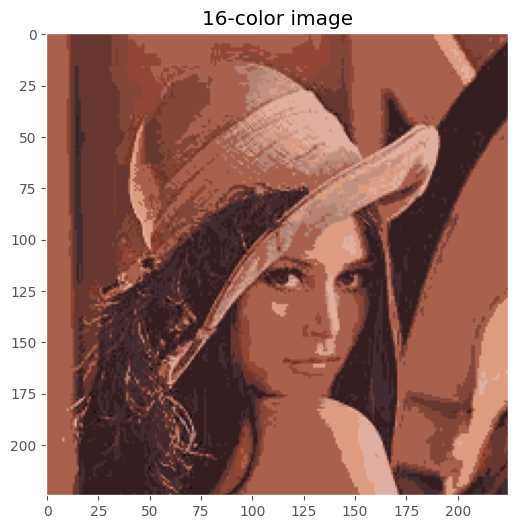

In [14]:
plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(lena_recolored, cv2.COLOR_BGR2RGB));
plt.title('16-color image')

Pretty cool, right?

Although some detail is arguably lost, overall, the preceding image is still clearly
recognizable. This is pretty remarkable, considering that we just compressed the image by a
factor of around 1 million!

You can repeat this procedure for any desired number of colors.